In [11]:
!rm -rf ./necrosis_frames
!rm -rf ./necrosis_frames_img
!rm -r ./*.mp4

rm: cannot remove './*.mp4': No such file or directory


🩶 INFORMATION NECROSIS — THE DEATH OF A POEM 🩶

Starting from: ./poem.txt

Using font sizes: Main=18, Title=24, Info=16
🩸 Iteration 0 | Original Poem
------------------------------------------------------------
I wandered lonely as a cloud
That floats on high o'er vales and hills,
When all at once I saw a crowd,
A host, of golden daffodils;
Beside the lake, beneath the trees,
Fluttering and dancing in the breeze.

Continuous as the stars that shine
And twinkle on the milky way,
They stretched in never-endi

...

🩸 Iteration 1 | Entropy: 4.482 | Decayed lines: 2
------------------------------------------------------------
I wandered lonely as a cloud
That floats on high o'er vales and hills,
When all at once I saw a crowd,
A host, of golden daffodils;
Beside the lake, beneath the trees,
Fluttering and dancing in the breeze.

Continuous as the stars that shine
And twinkle on the milky way,
They stretched in never-endi

...

🩸 Iteration 2 | Entropy: 4.482 | Decayed lines: 5
--------------

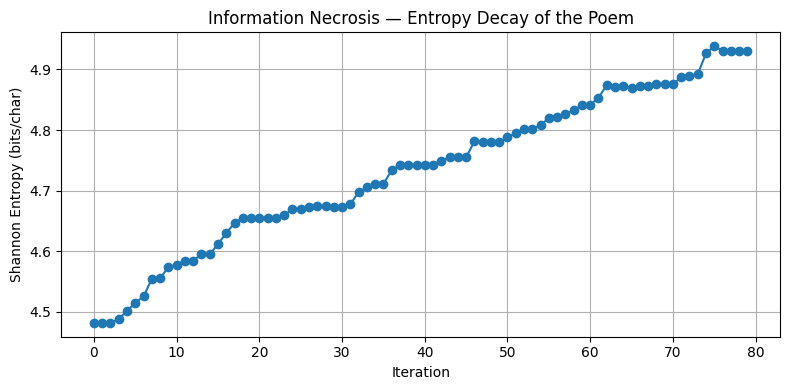


🕯️  The poem has decayed completely.
Frames saved in: necrosis_frames_img


In [12]:
import gzip
import io
import random
import string
import math
from collections import Counter
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# ===========================
# CONFIG
# ===========================
TEXT_FILE = "./poem.txt"   # put your poem here
ITERATIONS = 80           # how many decay cycles
NOISE_RATE = 0.02        # how fast meaning dies
OUTPUT_DIR = "necrosis_frames"  # will hold each decayed version
IMG_DIR = "necrosis_frames_img"

# ===========================
# UTILS
# ===========================
def compress_decompress(data: bytes) -> bytes:
    """Lossless churn: compress + decompress"""
    buf = io.BytesIO()
    with gzip.GzipFile(fileobj=buf, mode='wb') as f:
        f.write(data)
    compressed = buf.getvalue()
    with gzip.GzipFile(fileobj=io.BytesIO(compressed), mode='rb') as f:
        decompressed = f.read()
    return decompressed

def add_noise_to_text(data: str, rate=0.02) -> str:
    """Replace characters randomly to simulate decay"""
    chars = list(data)
    for i in range(len(chars)):
        if random.random() < rate:
            chars[i] = random.choice(string.printable)
    return "".join(chars)

def shannon_entropy(s: str) -> float:
    """Measure entropy (chaos) in bits per char"""
    counts = Counter(s)
    total = len(s)
    return -sum((count/total) * math.log2(count/total) for count in counts.values() if count)

def calculate_font_size(text):
    """Calculate appropriate font size based on poem length"""
    lines = text.splitlines()
    total_chars = sum(len(line) for line in lines)
    total_lines = len(lines)

    # Base font sizes
    if total_lines <= 10 and total_chars <= 500:
        # Small poem - larger fonts
        return 32, 40, 24
    elif total_lines <= 20 and total_chars <= 1000:
        # Medium poem - medium fonts
        return 24, 32, 20
    else:
        # Large poem - smaller fonts
        return 18, 24, 16

def decay_random_lines(text, decayed_lines_indices, noise_rate=0.02):
    """Decay random lines from the poem"""
    lines = text.splitlines()

    # Select 1-3 random lines to decay (or add new ones if we haven't decayed many yet)
    num_lines_to_decay = random.randint(1, 3)

    if len(decayed_lines_indices) < len(lines) * 0.3:  # First 30% of iterations
        # Focus on decaying new lines
        available_lines = [i for i in range(len(lines)) if i not in decayed_lines_indices]
        if available_lines:
            lines_to_decay = random.sample(available_lines, min(num_lines_to_decay, len(available_lines)))
        else:
            lines_to_decay = random.sample(range(len(lines)), min(num_lines_to_decay, len(lines)))
    else:
        # Decay any random lines (can be already decayed)
        lines_to_decay = random.sample(range(len(lines)), min(num_lines_to_decay, len(lines)))

    # Add newly decayed lines to our tracking set
    decayed_lines_indices.update(lines_to_decay)

    # Apply decay to selected lines
    for line_idx in lines_to_decay:
        if line_idx < len(lines):
            lines[line_idx] = add_noise_to_text(lines[line_idx], rate=noise_rate)

    return "\n".join(lines), decayed_lines_indices

def create_comparison_image(original_text, decayed_text, iteration, entropy):
    """Create side-by-side image showing original vs decayed poem"""
    img_width = 1920
    img_height = 1080
    img = Image.new("RGB", (img_width, img_height), color=(0, 0, 0))
    draw = ImageDraw.Draw(img)

    # Calculate font sizes based on original poem
    font_size, title_size, small_size = calculate_font_size(original_text)

    try:
        font = ImageFont.truetype("DejaVuSansMono.ttf", font_size)
        title_font = ImageFont.truetype("DejaVuSansMono.ttf", title_size)
        small_font = ImageFont.truetype("DejaVuSansMono.ttf", small_size)
    except:
        # Fallback to default fonts if DejaVu not available
        try:
            font = ImageFont.truetype("arial.ttf", font_size)
            title_font = ImageFont.truetype("arial.ttf", title_size)
            small_font = ImageFont.truetype("arial.ttf", small_size)
        except:
            font = ImageFont.load_default()
            title_font = ImageFont.load_default()
            small_font = ImageFont.load_default()

    # Calculate line spacing based on font size
    line_spacing = int(font_size * 1.3)

    # Draw titles
    draw.text((50, 30), "ORIGINAL POEM", fill=(255, 255, 255), font=title_font)
    draw.text((img_width//2 + 50, 30), f"DECAYED POEM (Iteration {iteration})",
              fill=(255, 100, 100), font=title_font)

    # Draw entropy info
    entropy_text = f"Entropy: {entropy:.3f} bits/char"
    draw.text((img_width//2 + 50, 85), entropy_text, fill=(200, 200, 100), font=small_font)

    # Draw progress info
    original_lines = original_text.splitlines()
    decayed_lines = decayed_text.splitlines()
    decayed_count = sum(1 for i, (orig, dec) in enumerate(zip(original_lines, decayed_lines))
                       if i < len(decayed_lines) and orig != dec)
    progress_text = f"Decayed lines: {decayed_count}/{len(original_lines)}"
    draw.text((img_width//2 + 50, 110), progress_text, fill=(200, 150, 150), font=small_font)

    # Draw separator line
    draw.line([(img_width//2, 0), (img_width//2, img_height)], fill=(100, 100, 100), width=3)

    # Draw original poem (left side)
    y_original = 150
    for line in original_text.splitlines():
        if y_original < img_height - 50:
            draw.text((50, y_original), line, fill=(200, 200, 255), font=font)
            y_original += line_spacing

    # Draw decayed poem (right side) with highlighting for decayed lines
    y_decayed = 150
    original_lines = original_text.splitlines()
    decayed_lines = decayed_text.splitlines()

    for i, line in enumerate(decayed_lines):
        if y_decayed < img_height - 50:
            if i < len(original_lines) and line != original_lines[i]:
                # Highlight decayed lines in red
                draw.text((img_width//2 + 50, y_decayed), line, fill=(255, 100, 100), font=font)
            else:
                # Normal color for unchanged lines
                draw.text((img_width//2 + 50, y_decayed), line, fill=(200, 200, 200), font=font)
            y_decayed += line_spacing

    return img

# ===========================
# MAIN
# ===========================
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
if not os.path.exists(IMG_DIR):
    os.makedirs(IMG_DIR)

# Load original poem
with open(TEXT_FILE, "r", encoding="utf-8", errors="ignore") as f:
    original_text = f.read()

text_stage = original_text
entropies = []
decayed_lines_indices = set()

print("🩶 INFORMATION NECROSIS — THE DEATH OF A POEM 🩶\n")
print(f"Starting from: {TEXT_FILE}\n")

# Calculate and display font info
font_size, title_size, small_size = calculate_font_size(original_text)
print(f"Using font sizes: Main={font_size}, Title={title_size}, Info={small_size}")

# First, save the original as iteration 0
original_img = create_comparison_image(original_text, original_text, 0, shannon_entropy(original_text))
original_img.save(os.path.join(IMG_DIR, "frame_00.png"))

print(f"🩸 Iteration 0 | Original Poem")
print("-" * 60)
print(original_text[:300])
print("\n...")

for i in range(ITERATIONS):
    # Decay random lines instead of the whole poem
    text_stage, decayed_lines_indices = decay_random_lines(text_stage, decayed_lines_indices, NOISE_RATE)

    # 3. measure entropy
    H = shannon_entropy(text_stage)
    entropies.append(H)

    # 4. show result
    print(f"\n🩸 Iteration {i+1} | Entropy: {H:.3f} | Decayed lines: {len(decayed_lines_indices)}")
    print("-" * 60)
    print(text_stage[:300])  # print part of decayed poem
    print("\n...")

    # 5. save this stage for animation later
    out_path = os.path.join(OUTPUT_DIR, f"decay_{i+1:02d}.txt")
    with open(out_path, "w", encoding="utf-8") as out:
        out.write(text_stage)

    # 6. create comparison image
    comparison_img = create_comparison_image(original_text, text_stage, i+1, H)
    img_path = os.path.join(IMG_DIR, f"frame_{i+1:02d}.png")
    comparison_img.save(img_path)

# ===========================
# VISUALIZE ENTROPY CURVE
# ===========================
plt.figure(figsize=(8,4))
plt.plot(range(ITERATIONS), entropies, marker='o')
plt.title("Information Necrosis — Entropy Decay of the Poem")
plt.xlabel("Iteration")
plt.ylabel("Shannon Entropy (bits/char)")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "entropy_decay.png"))
plt.show()

print("\n🕯️  The poem has decayed completely.")
print(f"Frames saved in: {IMG_DIR}")

In [13]:
import os
!ffmpeg -framerate 0.7 -i ./necrosis_frames_img/frame_%02d.png -vf "scale=1920:1080" -c:v libx264 -pix_fmt yuv420p necrosis_comparison.mp4 -y

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab